Part 0: Setup

In [143]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [144]:
import scipy as sp 
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold


In [145]:
pdf = pd.read_csv(r"C:\Users\mikey\OneDrive\Desktop\nbaproj\data\output.csv", delim_whitespace=True)

C:\Users\mikey\AppData\Local\Temp\ipykernel_18708\1423716347.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pdf = pd.read_csv(r"C:\Users\mikey\OneDrive\Desktop\nbaproj\data\output.csv", delim_whitespace=True)


In [146]:
pdf.drop(['Team'], axis=1,inplace=True)

In [147]:
# Create a mapping for positions
position_mapping = {
    'C': 5,   # Center
    'PF': 4,  # Power Forward
    'SF': 3,  # Small Forward
    'SG': 2,  # Shooting Guard
    'PG': 1   # Point Guard
}

# Apply the mapping to the 'Pos' column
pdf['POS'] = pdf['Pos'].map(position_mapping)
pdf.drop('Pos', axis=1, inplace=True)

In [148]:
pdf.isna().sum()

Player      0
Age         0
G           0
GS          0
MP          0
PER         0
TS%         0
3PAr        0
FTr         0
ORB%        0
DRB%        1
TRB%        1
AST%        1
STL%        1
BLK%        1
TOV%        1
USG%        1
OWS         1
DWS         1
WS          1
WS/48       1
OBPM        4
DBPM        4
BPM         5
VORP        5
Awards    547
POS         1
dtype: int64

In [149]:
mean_values = pdf.select_dtypes(include=['number']).mean()
pdf = pdf.fillna(mean_values)  # Overwrite `pdf` with the filled version

In [150]:
pdf.isna().sum() #checking for NaN

Player      0
Age         0
G           0
GS          0
MP          0
PER         0
TS%         0
3PAr        0
FTr         0
ORB%        0
DRB%        0
TRB%        0
AST%        0
STL%        0
BLK%        0
TOV%        0
USG%        0
OWS         0
DWS         0
WS          0
WS/48       0
OBPM        0
DBPM        0
BPM         0
VORP        0
Awards    547
POS         0
dtype: int64

              Age           G          GS           MP         PER  \
count  547.000000  547.000000  547.000000   547.000000  547.000000   
mean    25.796296   25.901280   11.979890   578.444241   12.995978   
std      4.371022   13.381187   15.132914   458.010795    8.742602   
min      0.574000    1.000000    0.000000     1.000000  -36.900000   
25%     23.000000   14.000000    0.000000   153.500000   10.000000   
50%     25.000000   29.000000    3.000000   534.000000   12.900000   
75%     28.000000   38.000000   23.000000   954.500000   16.500000   
max     40.000000   45.000000   45.000000  1736.000000  118.600000   

              TS%        3PAr         FTr        ORB%        DRB%  ...  \
count  547.000000  547.000000  547.000000  547.000000  547.000000  ...   
mean     0.546062    0.772314    0.507457    5.595430   14.520513  ...   
std      0.153412    4.969021    3.070183    5.259615    7.088608  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   

Text(0.5, 1.0, 'Overall VORP Distribution')

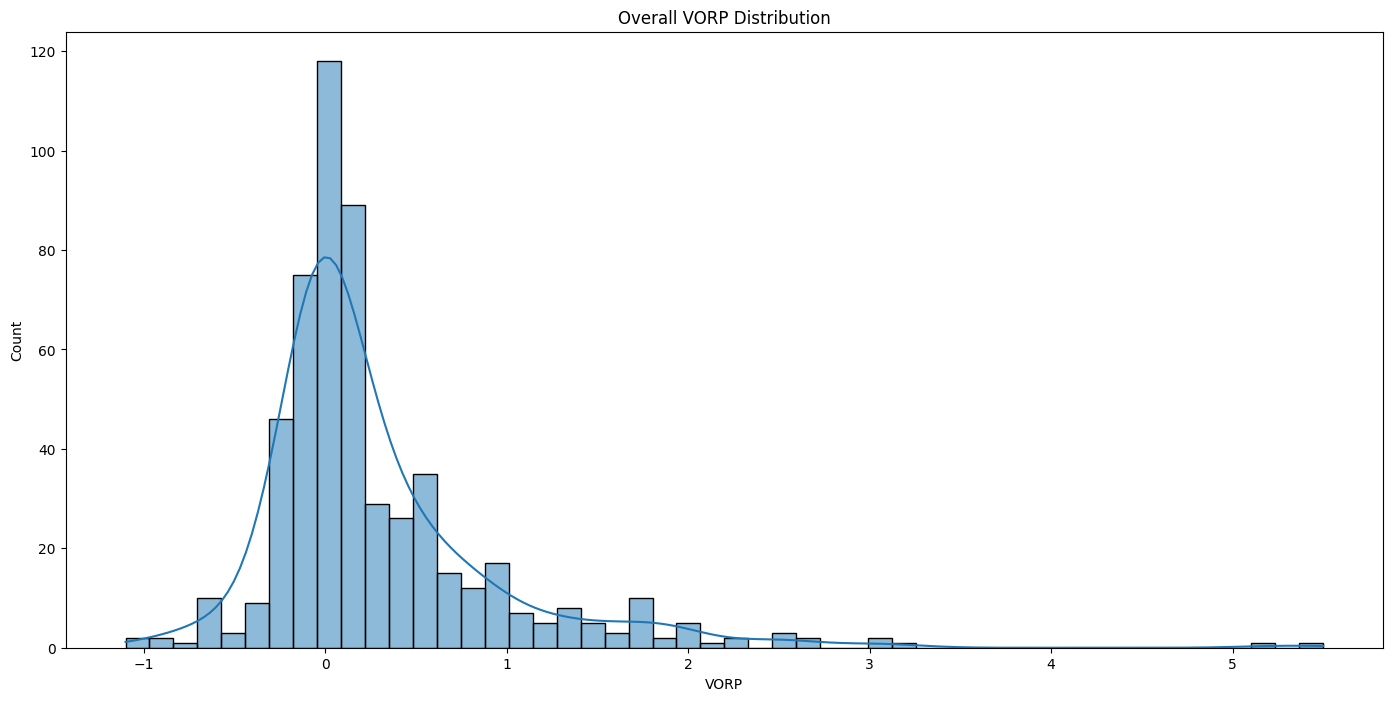

In [151]:
print(pdf.describe())
plt.figure(figsize=(17,8))
sns.histplot(pdf['VORP'], kde=True)
plt.title("Overall VORP Distribution")

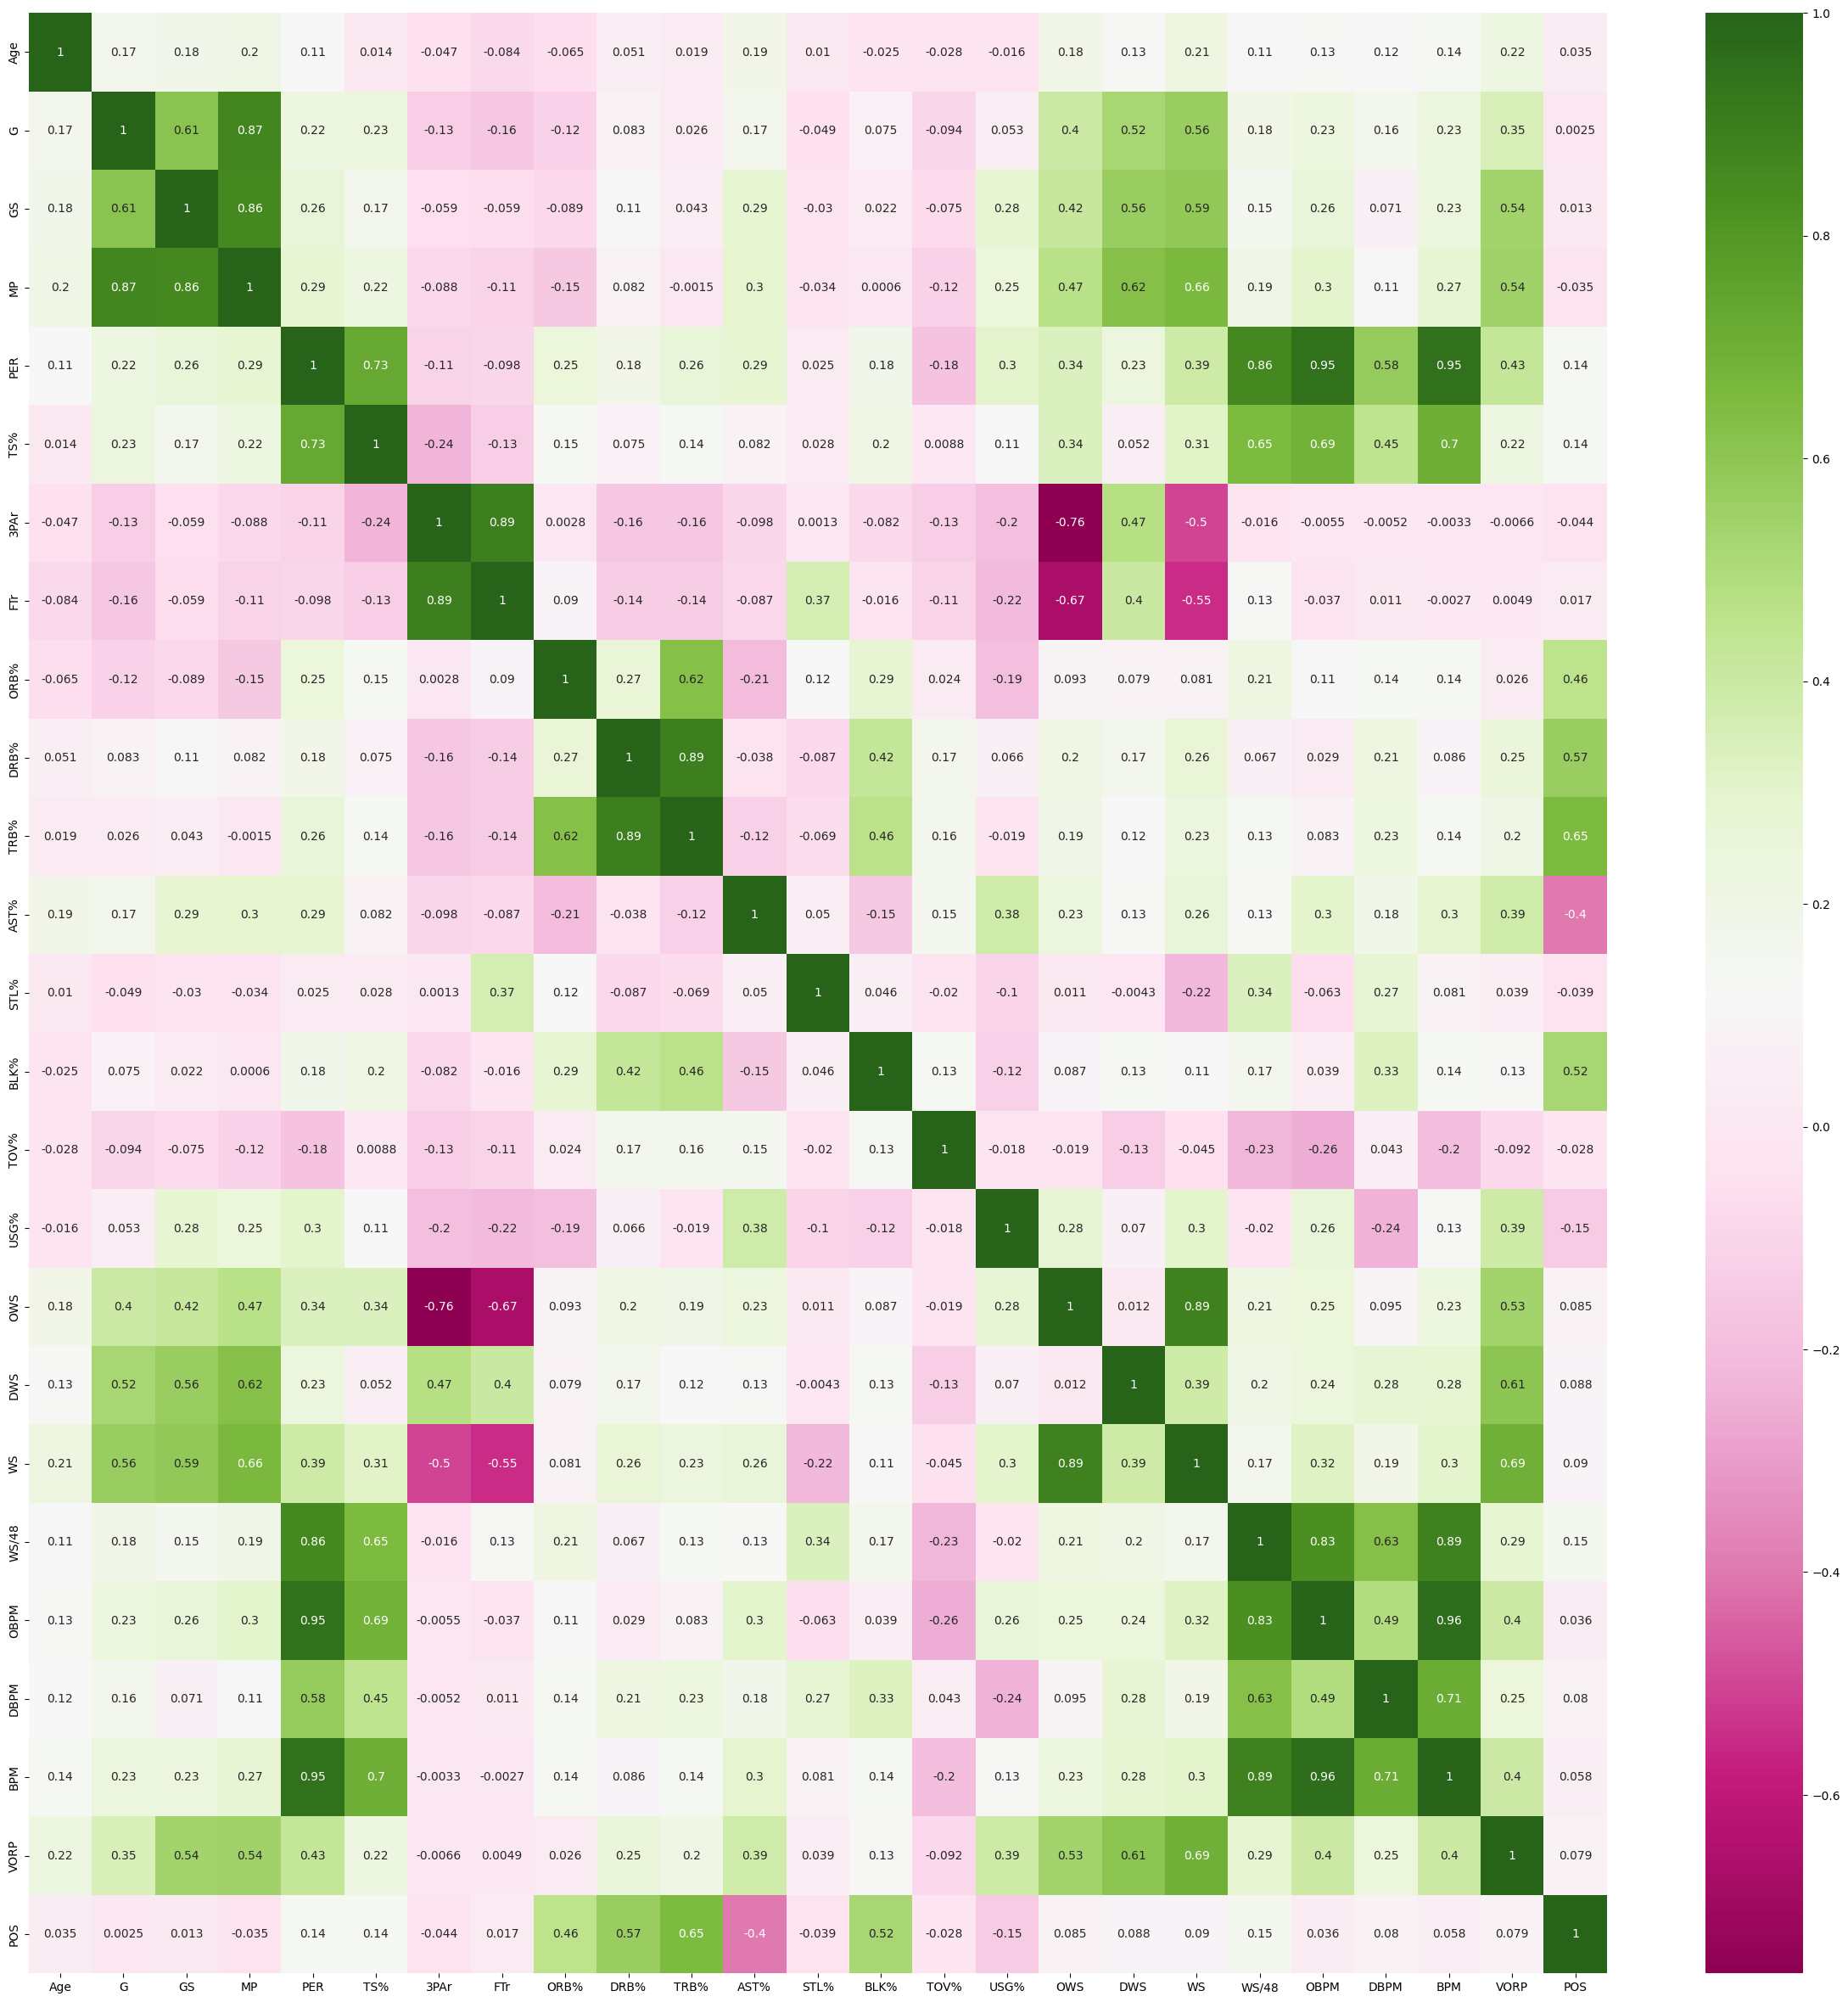

In [152]:
plt.figure(figsize=(30,30))
heatmap_data = pdf.select_dtypes(include=['number'])
heatmap_data.drop('Awards', axis=1, inplace=True)
sns.heatmap(data=heatmap_data.corr(),annot=True, cmap='PiYG')
plt.show()

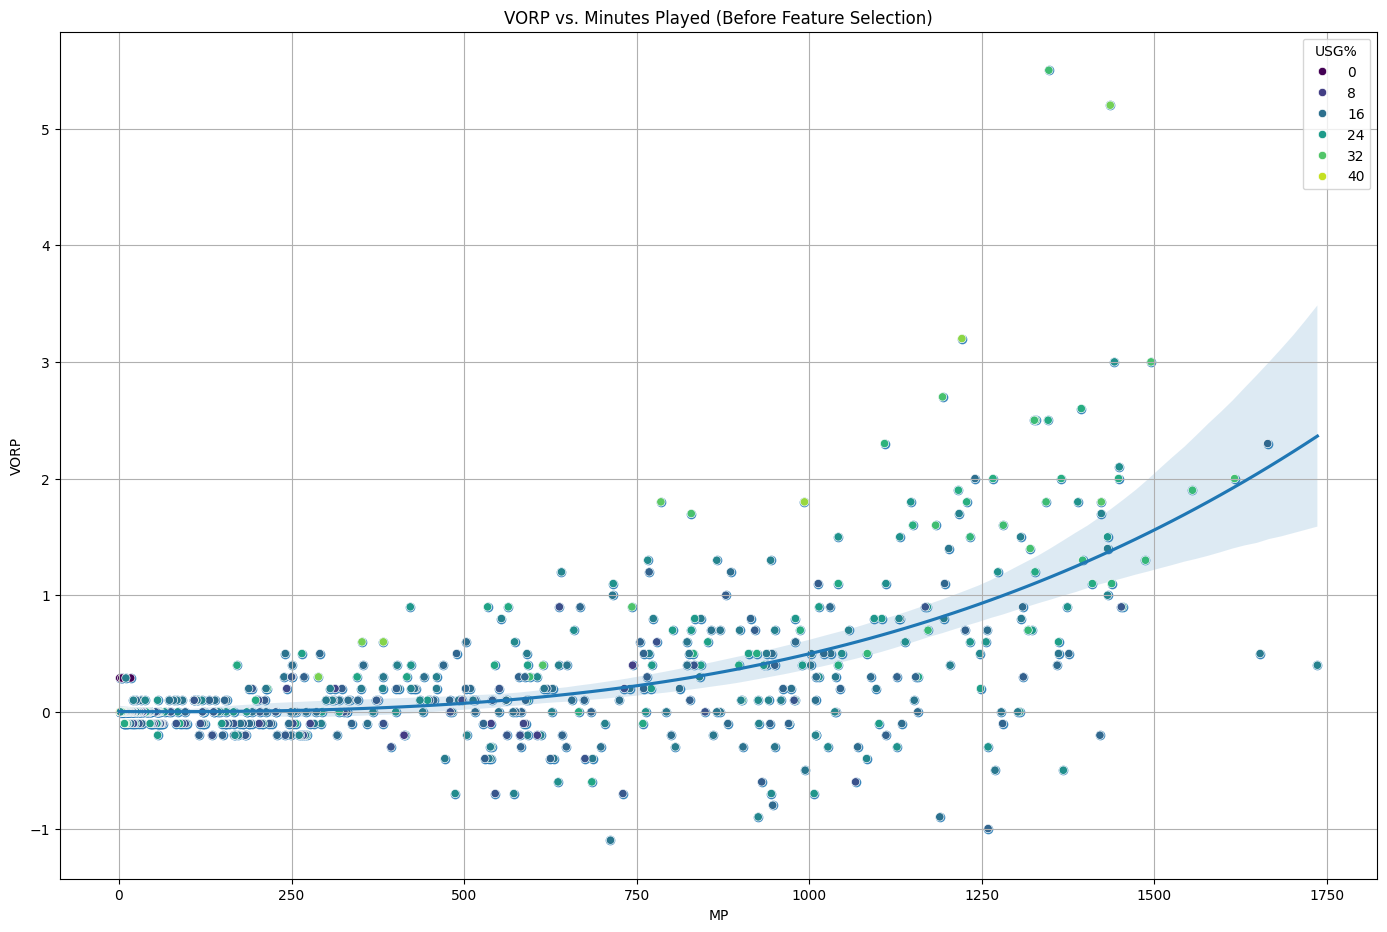

In [153]:
# Early EDA: Raw feature relationships
plt.figure(figsize=(17, 11))
sns.regplot(x='MP', y='VORP', data=pdf,order=3)
sns.scatterplot(x='MP', y='VORP', data=pdf, hue='USG%', palette='viridis')
plt.title("VORP vs. Minutes Played (Before Feature Selection)")
plt.grid(True)


In [154]:
Q1 = pdf['VORP'].quantile(0.25)
Q3 = pdf['VORP'].quantile(0.75)
IQR = Q3 - Q1
outliers_boolean = (pdf['VORP'] < Q1 - 1.5 * IQR) | (pdf['VORP'] > Q3 + 1.5 * IQR)
pdf['VORP Outliers'] = [False] * len(pdf)
pdf.loc[outliers_boolean, 'VORP Outliers'] = True
pdf['VORP Outliers'] = pdf['VORP Outliers'].fillna(False)


                      Player   WS  VORP      MP
1                  Josh Hart  6.2   2.3  1664.0
3            Anthony Edwards  3.6   2.0  1616.0
4              Jalen Brunson  6.1   1.9  1555.0
5               Jayson Tatum  6.0   3.0  1495.0
6               De'Aaron Fox  3.8   1.3  1487.0
9          Tyrese Haliburton  4.9   2.1  1449.0
10               Tyler Herro  4.4   2.0  1448.0
11          Domantas Sabonis  7.0   3.0  1442.0
13   Shai Gilgeous-Alexander  9.6   5.2  1436.0
14             Pascal Siakam  4.6   1.5  1432.0
16             Fred VanVleet  4.2   1.4  1432.0
17           Cade Cunningham  2.8   1.8  1423.0
18             Derrick White  4.2   1.7  1423.0
21              Devin Booker  4.1   1.3  1396.0
22        Karl-Anthony Towns  7.0   2.6  1394.0
23          Nikola VuÄeviÄ  5.0   1.8  1389.0
27            Jalen Williams  4.5   2.0  1365.0
31             Nikola JokiÄ  9.2   5.5  1347.0
32          Alperen ÅengÃ¼n  5.2   2.5  1346.0
33              James Harden  3.2   1.8 

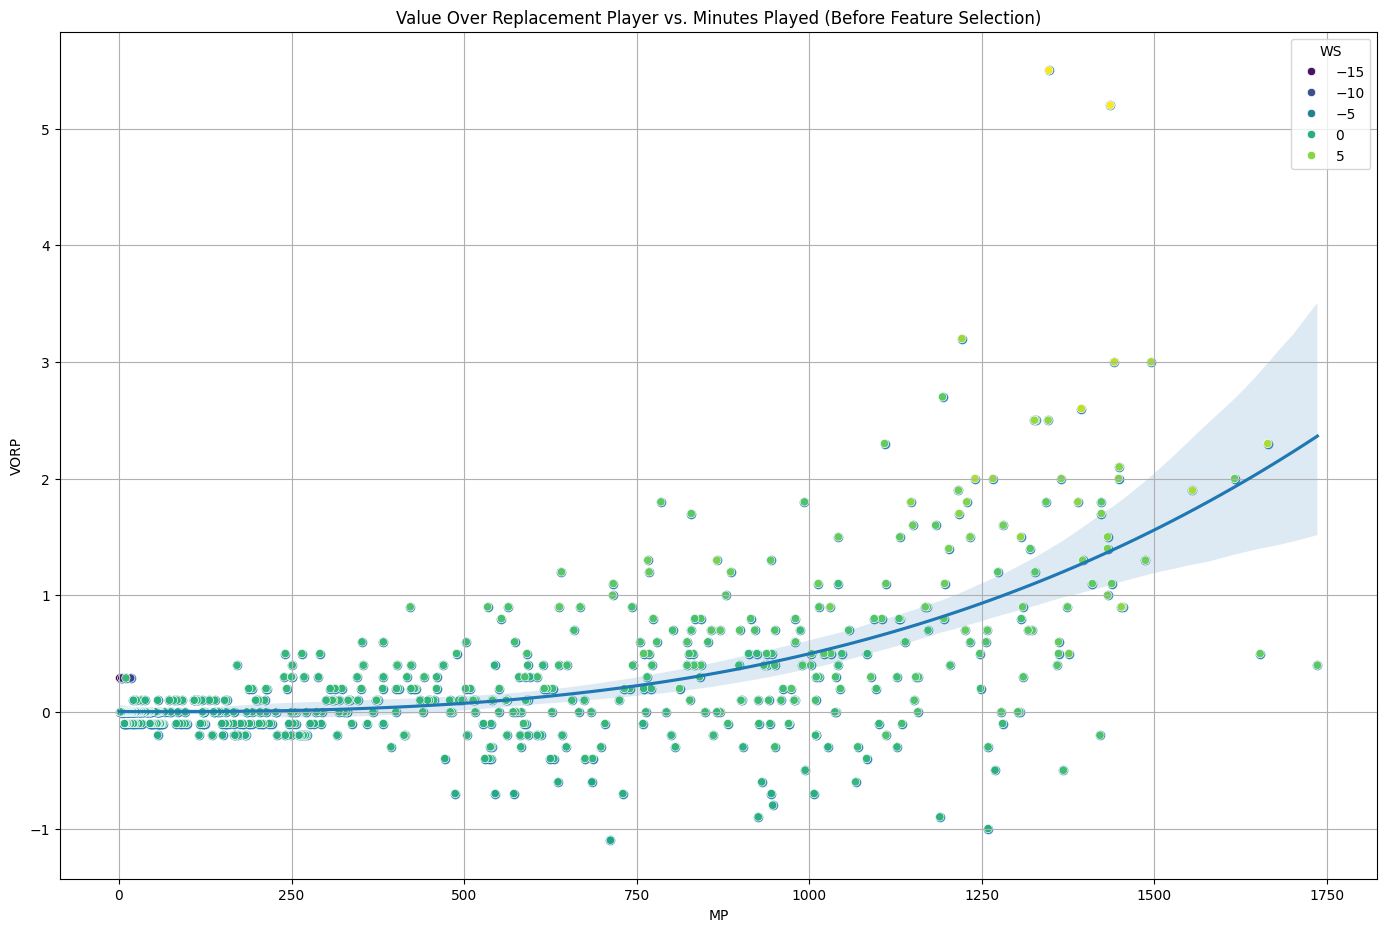

In [155]:
plt.figure(figsize=(17, 11))
sns.regplot(x='MP', y='VORP', data=pdf,order=3)
sns.scatterplot(x='MP', y='VORP', data=pdf, hue='WS', palette='viridis')
plt.title("Value Over Replacement Player vs. Minutes Played (Before Feature Selection)")
plt.grid(True)
condition = pdf['VORP Outliers'] == True
outliers_data = pdf.loc[condition,['Player', 'WS', 'VORP', 'MP']]
print(outliers_data)

                      Player   WS  VORP      MP
1                  Josh Hart  6.2   2.3  1664.0
3            Anthony Edwards  3.6   2.0  1616.0
4              Jalen Brunson  6.1   1.9  1555.0
5               Jayson Tatum  6.0   3.0  1495.0
6               De'Aaron Fox  3.8   1.3  1487.0
9          Tyrese Haliburton  4.9   2.1  1449.0
10               Tyler Herro  4.4   2.0  1448.0
11          Domantas Sabonis  7.0   3.0  1442.0
13   Shai Gilgeous-Alexander  9.6   5.2  1436.0
14             Pascal Siakam  4.6   1.5  1432.0
16             Fred VanVleet  4.2   1.4  1432.0
17           Cade Cunningham  2.8   1.8  1423.0
18             Derrick White  4.2   1.7  1423.0
21              Devin Booker  4.1   1.3  1396.0
22        Karl-Anthony Towns  7.0   2.6  1394.0
23          Nikola VuÄeviÄ  5.0   1.8  1389.0
27            Jalen Williams  4.5   2.0  1365.0
31             Nikola JokiÄ  9.2   5.5  1347.0
32          Alperen ÅengÃ¼n  5.2   2.5  1346.0
33              James Harden  3.2   1.8 

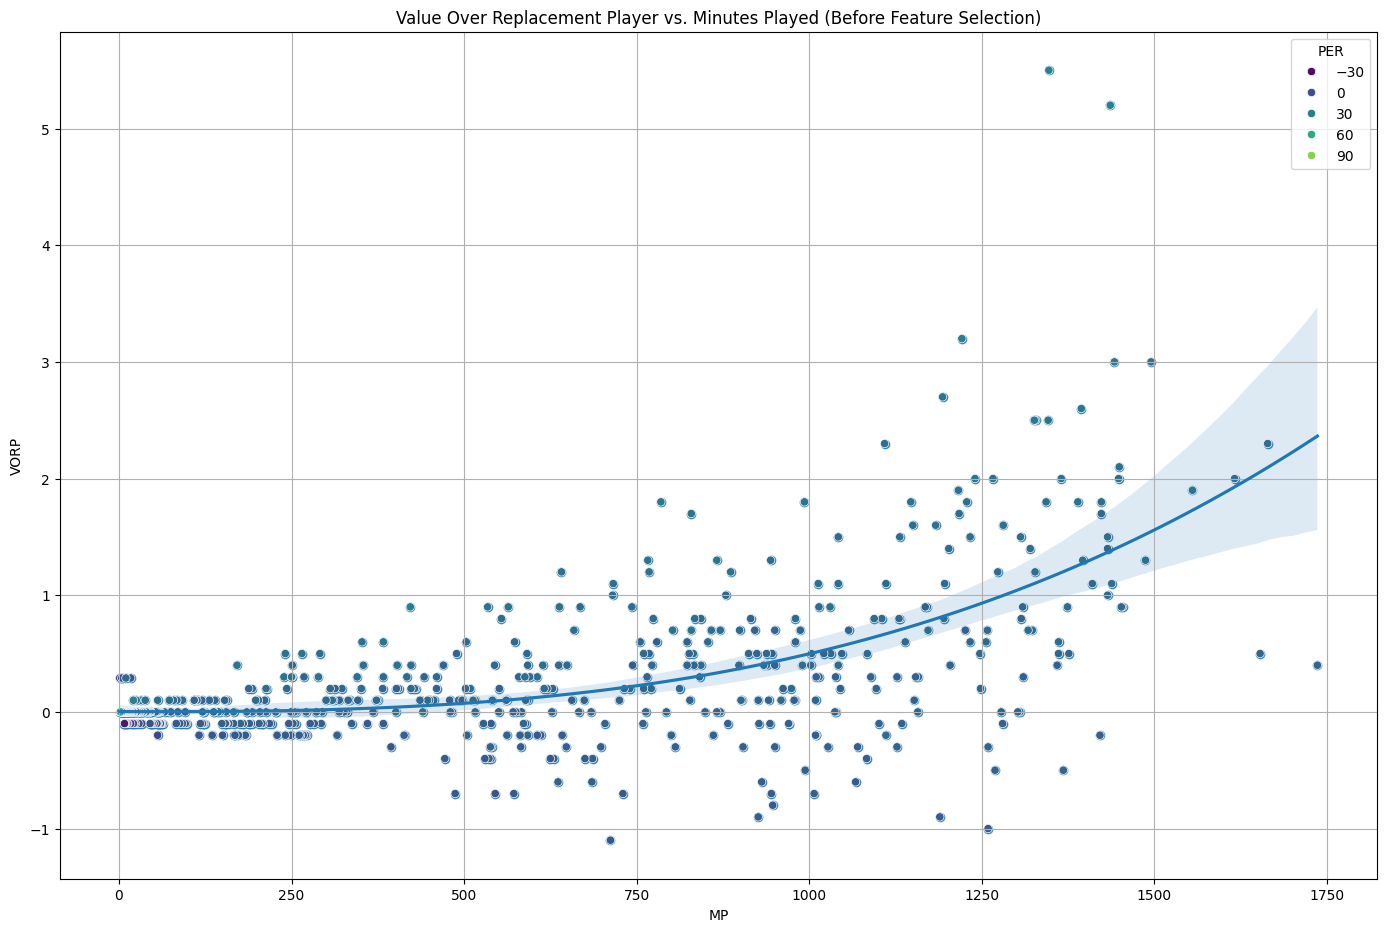

In [156]:
plt.figure(figsize=(17, 11))
sns.regplot(x='MP', y='VORP', data=pdf,order=3)
sns.scatterplot(x='MP', y='VORP', data=pdf, hue='PER', palette='viridis')
plt.title("Value Over Replacement Player vs. Minutes Played (Before Feature Selection)")
plt.grid(True)
condition = pdf['VORP Outliers'] == True
outliers_data = pdf.loc[condition,['Player', 'WS', 'VORP', 'MP']]
print(outliers_data)

                      Player   WS  VORP      MP
1                  Josh Hart  6.2   2.3  1664.0
3            Anthony Edwards  3.6   2.0  1616.0
4              Jalen Brunson  6.1   1.9  1555.0
5               Jayson Tatum  6.0   3.0  1495.0
6               De'Aaron Fox  3.8   1.3  1487.0
9          Tyrese Haliburton  4.9   2.1  1449.0
10               Tyler Herro  4.4   2.0  1448.0
11          Domantas Sabonis  7.0   3.0  1442.0
13   Shai Gilgeous-Alexander  9.6   5.2  1436.0
14             Pascal Siakam  4.6   1.5  1432.0
16             Fred VanVleet  4.2   1.4  1432.0
17           Cade Cunningham  2.8   1.8  1423.0
18             Derrick White  4.2   1.7  1423.0
21              Devin Booker  4.1   1.3  1396.0
22        Karl-Anthony Towns  7.0   2.6  1394.0
23          Nikola VuÄeviÄ  5.0   1.8  1389.0
27            Jalen Williams  4.5   2.0  1365.0
31             Nikola JokiÄ  9.2   5.5  1347.0
32          Alperen ÅengÃ¼n  5.2   2.5  1346.0
33              James Harden  3.2   1.8 

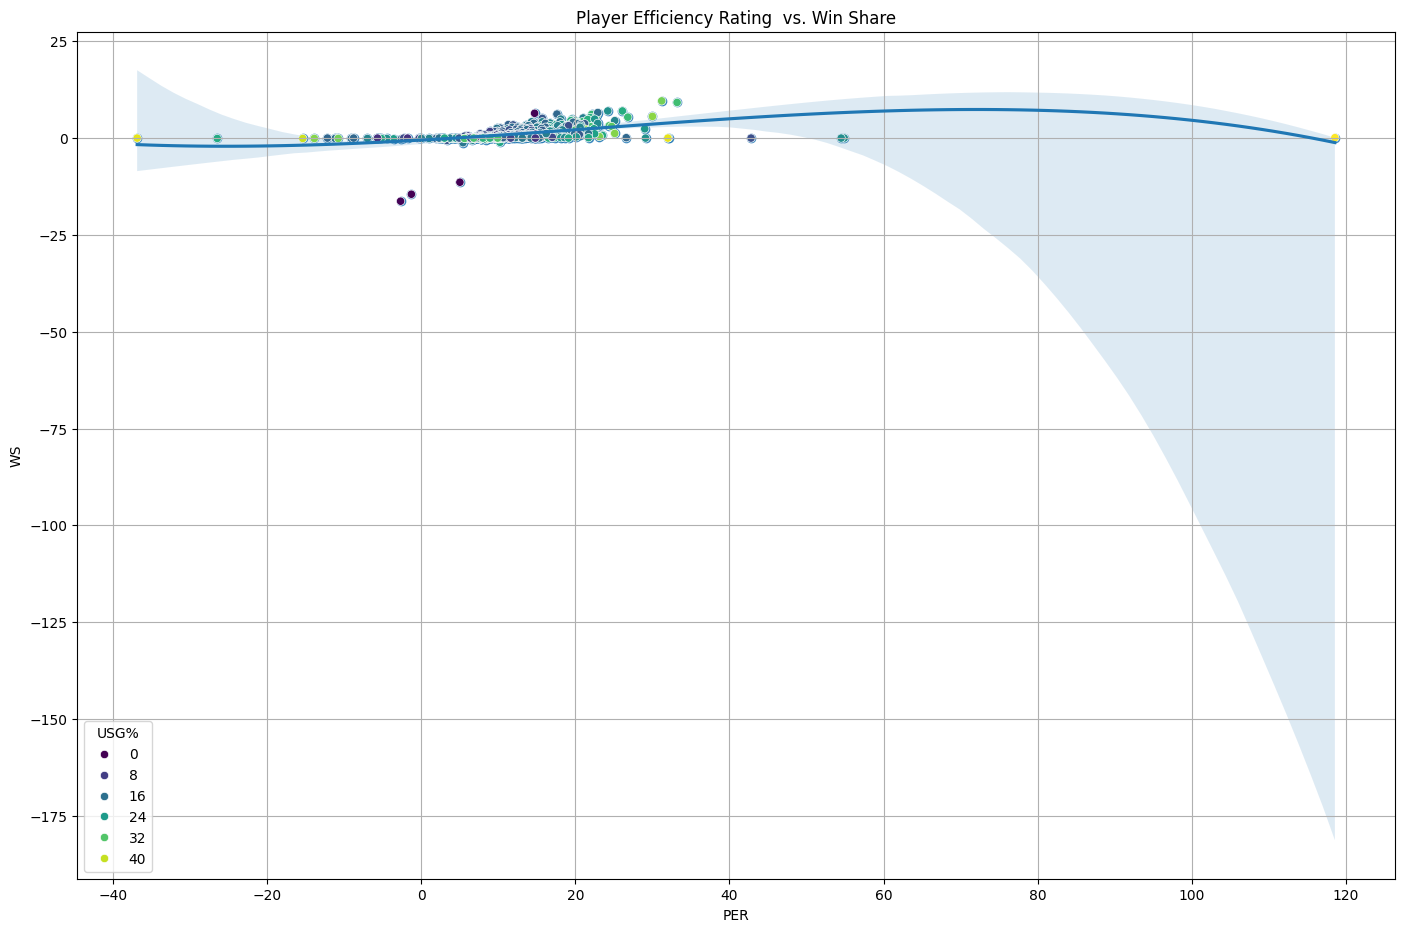

In [157]:
plt.figure(figsize=(17, 11))
sns.regplot(x='PER', y='WS', data=pdf,order=3)
sns.scatterplot(x='PER', y='WS', data=pdf, hue='USG%', palette='viridis')
plt.title("Player Efficiency Rating  vs. Win Share")
plt.grid(True)
condition = pdf['VORP Outliers'] == True
outliers_data = pdf.loc[condition,['Player', 'WS', 'VORP', 'MP']]
print(outliers_data)

In [158]:
pdf['AST/36'] = pdf['AST%'] * (1/36)

In [159]:
pdf.drop('Awards', axis=1, inplace=True)

In [160]:
train_data, test_data = train_test_split(pdf, test_size=0.2, random_state=42)

In [161]:
X_train = train_data.drop(['VORP','Player'], axis=1) 
y_train = train_data['VORP']    

# Test set
X_test = test_data.drop(['VORP','Player'], axis=1) 
y_test = test_data['VORP'] 

In [162]:
train_names = train_data['Player']
test_names = test_data['Player']

In [163]:
from sklearn.preprocessing import RobustScaler

In [164]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

In [165]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [166]:
alphas = np.logspace(-4, 0, 50) 
model = LassoCV(alphas=alphas, cv=5, random_state=42)
model.fit(X_train, y_train)

print(f"Best alpha: {model.alpha_:.4f}")
print(f"Best CV R²: {model.score(X_train, y_train):.2f}")

Best alpha: 0.1265
Best CV R²: 0.72


c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07736818276448787, tolerance: 0.014112198758303893
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1316078460029324, tolerance: 0.014112198758303893
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.061709840911245095, tolerance: 0.014112198758303893
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did n

In [167]:
model = Lasso(alpha=0.1265)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
model.fit(X_train, y_train)

print(f"Mean R²: {scores.mean():.2f} (±{scores.std():.2f})")

Mean R²: 0.60 (±0.12)


Key Drivers of VORP:
WS      0.203129
FTr     0.041164
3PAr    0.018029
USG%    0.012602
AST%    0.011369
BPM     0.010224
DRB%    0.009275
STL%    0.008708
Age     0.002918
MP      0.000379
TOV%   -0.002140
G      -0.009833
dtype: float64


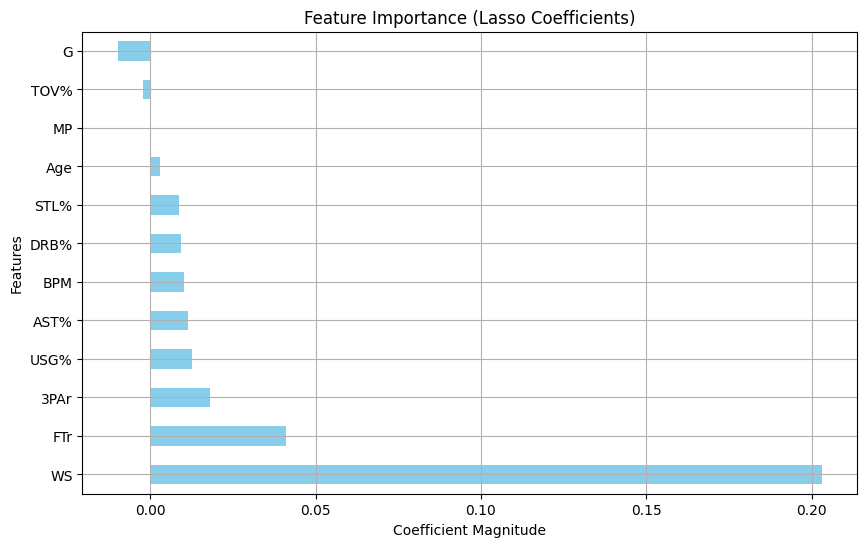

In [168]:
coefficients = pd.Series(model.coef_, index=X_train.columns)
significant_features = coefficients[coefficients != 0].sort_values(ascending=False)

print("Key Drivers of VORP:")
print(significant_features)

plt.figure(figsize=(10, 6))
significant_features.plot(kind='barh', color='skyblue')
plt.title("Feature Importance (Lasso Coefficients)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.grid(True)

In [170]:
from sklearn.metrics import r2_score

In [171]:
model_final = Lasso(alpha=model.alpha)
model_final.fit(X_train, y_train)

X_test = test_data.drop(['VORP', 'Player'], axis=1) 
y_test = test_data['VORP']
y_pred = model_final.predict(X_test)

# Evaluate
test_r2 = r2_score(y_test, y_pred)
print(f"Test R²: {test_r2:.2f}")

Test R²: 0.75


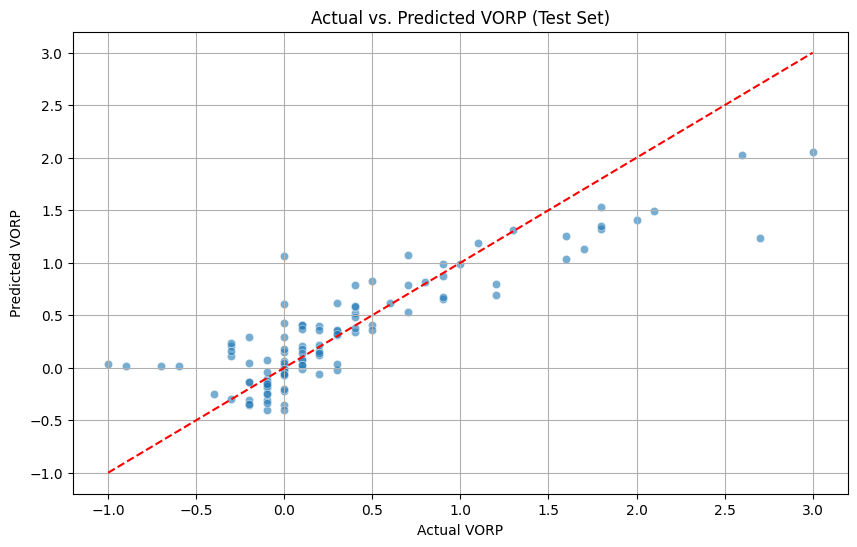

In [172]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual VORP")
plt.ylabel("Predicted VORP")
plt.title("Actual vs. Predicted VORP (Test Set)")
plt.grid(True)

Optimal alpha for Ridge Regression: 100.0
Test R²: 0.86
Test MAE: 0.18
Test MSE: 0.07
Test RMSE: 0.26


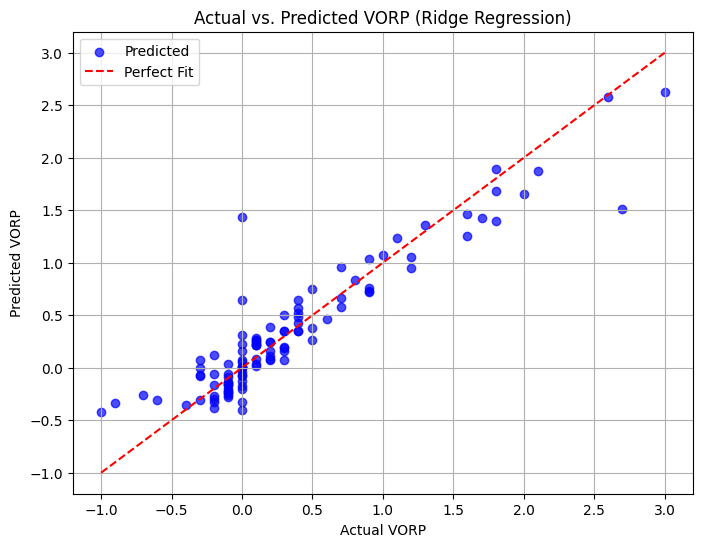

In [173]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

alpha_range = {'alpha': np.logspace(-3, 2, 10)} 

ridge_cv = GridSearchCV(Ridge(), param_grid=alpha_range, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Optimal alpha for Ridge Regression: {best_alpha}")

# Train Ridge Regression with the best alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

# Predict on test data
y_pred = ridge_model.predict(X_test)

# Evaluate performance
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Plot Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")  # Diagonal line
plt.xlabel('Actual VORP')
plt.ylabel('Predicted VORP')
plt.title('Actual vs. Predicted VORP (Ridge Regression)')
plt.legend()
plt.grid(True)
plt.show()


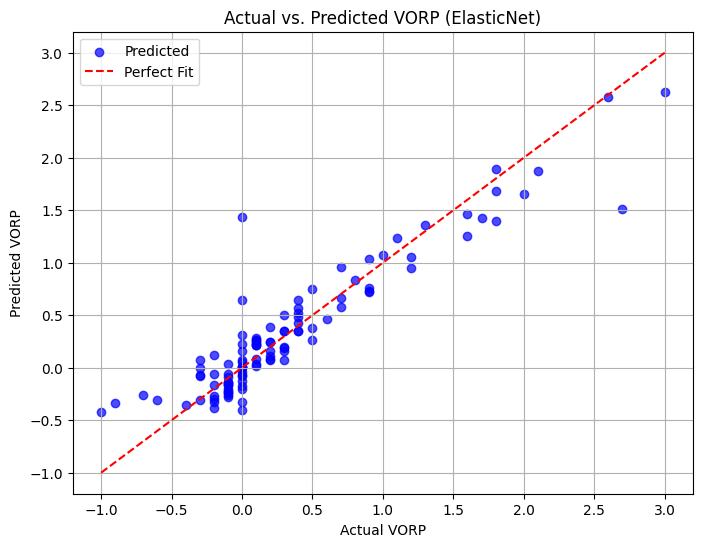

In [176]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1265, l1_ratio=0.5)  # l1_ratio balances Lasso & Ridge effects
model.fit(X_train, y_train)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")  # Diagonal line
plt.xlabel('Actual VORP')
plt.ylabel('Predicted VORP')
plt.title('Actual vs. Predicted VORP (ElasticNet)')
plt.legend()
plt.grid(True)
plt.show()
